# Выявить зависимость числа bugs от других характеристик

belbor1@gmail.com

In [1]:
import pandas as pd
import numpy as np
import datetime as dt

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [3]:
from scipy.stats.stats import pearsonr
from sklearn.metrics import mean_squared_error

## Анализ данных

In [4]:
data = pd.read_csv('dataset/train.csv')
data.head()

,repository_name,commit_hash,commit_date,commit_author,commit_message,bugs
0,mlm,b28abb42,2020-06-12T14:26:12,Victor,объяснения предсказаний с помощью lime,4
1,mlm,438b5c4d,2020-06-12T11:53:10,Victor,Поставил lime вместо eli5,3
2,mlm,8e6e4f31,2020-06-11T15:19:03,Victor,Скрипт для создния пакетов обновления,4
3,mlm,5e0956a6,2020-06-11T10:42:29,Victor,Сортировка весов по убыванию,3
4,mlm,b9f4b40c,2020-06-11T09:25:19,Victor,не надо конвертировать массив до операции по с...,7


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319 entries, 0 to 318
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repository_name  319 non-null    object
 1   commit_hash      319 non-null    object
 2   commit_date      319 non-null    object
 3   commit_author    319 non-null    object
 4   commit_message   319 non-null    object
 5   bugs             319 non-null    int64 
dtypes: int64(1), object(5)
memory usage: 15.1+ KB


In [6]:
data.describe()

,bugs
count,319.000000
mean,2.996865
std,1.855636
min,0.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,12.000000


Мы располагаем небольшим объемом данных. Всего 319 строк х 6 столбцов. Пропуски отсутствуют. Рассмотрим данные каждого столбца в отдельности.

### Bugs

2     96
3     75
4     51
1     44
5     19
6     10
0      8
7      7
8      3
12     2
9      2
11     1
10     1
Name: bugs, dtype: int64


<AxesSubplot:>

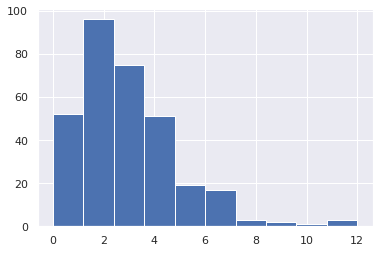

In [7]:
print(data.bugs.value_counts())
data.bugs.hist()

In [8]:
data.bugs.describe()

count    319.000000
mean       2.996865
std        1.855636
min        0.000000
25%        2.000000
50%        3.000000
75%        4.000000
max       12.000000
Name: bugs, dtype: float64

<AxesSubplot:xlabel='bugs'>

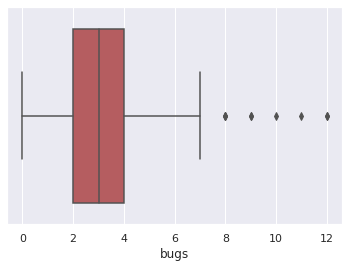

In [9]:
sns.boxplot(data=data, x='bugs', color='r')

50% наблюдений имеют значение багов от 2 до 4. Распределение характеристики отражено на гистограмме. Аномальных значений не обнаружено. Значения больше (или равно) 8 относятся к выбросам. Позже устраним их из нашего датасета.

### Commit_author

Victor     134
Mallory     67
Wendy       48
Dabe        42
Eve          9
Trudy        9
Carol        4
Peggy        2
Alice        2
Bob          2
Name: commit_author, dtype: int64


<AxesSubplot:>

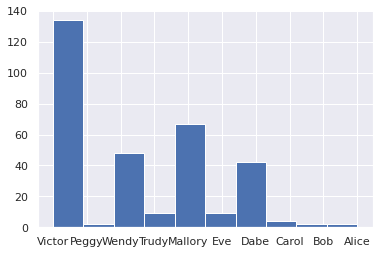

In [10]:
print(data.commit_author.value_counts())
data.commit_author.hist()

<AxesSubplot:xlabel='commit_author', ylabel='bugs'>

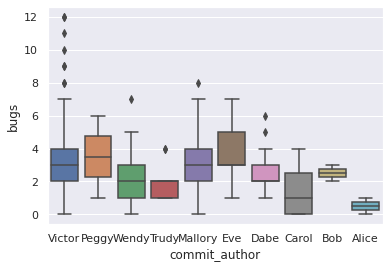

In [11]:
sns.boxplot(data=data, x='commit_author', y='bugs')

Количество багов различается в зависиомсти от пользователя. Имя пользователя хороший параметр для модели.

### Repository_name

conductor    114
sensor       102
mlm           41
standard      29
dockers       19
agent         14
Name: repository_name, dtype: int64


<AxesSubplot:>

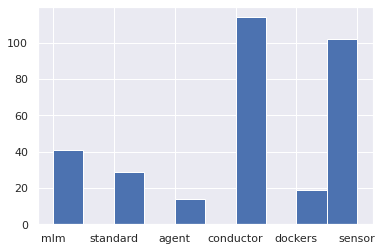

In [12]:
print(data.repository_name.value_counts())
data.repository_name.hist()

<AxesSubplot:xlabel='repository_name', ylabel='bugs'>

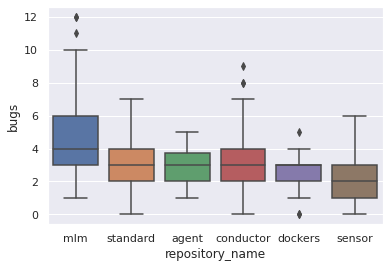

In [13]:
sns.boxplot(data=data, x='repository_name', y='bugs')

В меньшей мере количество багов связано с репозиторием. Однако тоже различается по этому параметру.

### Commit_hash

In [14]:
data.commit_hash.nunique() == len(data)

True

Commit_hash - уникальное значение. Мы можем отказаться от этого параметра

### Commit_massage

In [15]:
data.commit_message.nunique()

309

С текстом коммита надо поработать. Попробуем учесть эту характеристику через длину коммита. 

## Подготовка данных для расчетов

In [16]:
# убираем выбросы по количеству багов
data = data[data['bugs'] < 8]

In [17]:
X_train = data.iloc[:, 0:5].copy()
Y_train = data.iloc[:, 5].copy()

In [18]:
X_train.head()

,repository_name,commit_hash,commit_date,commit_author,commit_message
0,mlm,b28abb42,2020-06-12T14:26:12,Victor,объяснения предсказаний с помощью lime
1,mlm,438b5c4d,2020-06-12T11:53:10,Victor,Поставил lime вместо eli5
2,mlm,8e6e4f31,2020-06-11T15:19:03,Victor,Скрипт для создния пакетов обновления
3,mlm,5e0956a6,2020-06-11T10:42:29,Victor,Сортировка весов по убыванию
4,mlm,b9f4b40c,2020-06-11T09:25:19,Victor,не надо конвертировать массив до операции по с...


In [19]:
Y_train.head()

0    4
1    3
2    4
3    3
4    7
Name: bugs, dtype: int64

### Commit_author and repository_name

In [20]:
# Закодируем имена авторов
categorical_subs = pd.get_dummies(X_train[['commit_author', 'repository_name']])
categorical_subs

,commit_author_Alice,commit_author_Bob,commit_author_Carol,commit_author_Dabe,commit_author_Eve,commit_author_Mallory,commit_author_Peggy,commit_author_Trudy,commit_author_Victor,commit_author_Wendy,repository_name_agent,repository_name_conductor,repository_name_dockers,repository_name_mlm,repository_name_sensor,repository_name_standard
0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
315,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
316,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
317,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0


In [21]:
X_train = X_train.merge(categorical_subs, 
                        how='inner', left_index=True, 
                        right_index=True).drop(columns=['commit_author', 
                                                        'repository_name'], 
                                               axis=1)

### Data

<AxesSubplot:>

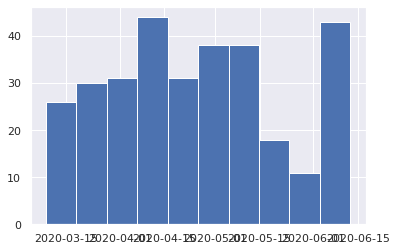

In [22]:
# Преобразуем дату из строки в datetime
X_train.commit_date = pd.to_datetime(X_train.commit_date)
X_train.commit_date.hist()

In [23]:
# Обработаем даты: разобъем и преобразуем
X_train['year'] = X_train.commit_date.apply(lambda x: x.year)
X_train['month'] = X_train.commit_date.apply(lambda x: x.month)
X_train['day'] = X_train.commit_date.apply(lambda x: x.day)
X_train['hour'] = X_train.commit_date.apply(lambda x: x.hour 
                                            + x.minute/60).round(2)
X_train['weekday'] = X_train.commit_date.apply(lambda x: x.weekday())

In [24]:
X_train = X_train.drop('commit_date', axis=1)

In [25]:
X_train.head()

,commit_hash,commit_message,commit_author_Alice,commit_author_Bob,commit_author_Carol,commit_author_Dabe,commit_author_Eve,commit_author_Mallory,commit_author_Peggy,commit_author_Trudy,...,repository_name_conductor,repository_name_dockers,repository_name_mlm,repository_name_sensor,repository_name_standard,year,month,day,hour,weekday
0,b28abb42,объяснения предсказаний с помощью lime,0,0,0,0,0,0,0,0,...,0,0,1,0,0,2020,6,12,14.43,4
1,438b5c4d,Поставил lime вместо eli5,0,0,0,0,0,0,0,0,...,0,0,1,0,0,2020,6,12,11.88,4
2,8e6e4f31,Скрипт для создния пакетов обновления,0,0,0,0,0,0,0,0,...,0,0,1,0,0,2020,6,11,15.32,3
3,5e0956a6,Сортировка весов по убыванию,0,0,0,0,0,0,0,0,...,0,0,1,0,0,2020,6,11,10.70,3
4,b9f4b40c,не надо конвертировать массив до операции по с...,0,0,0,0,0,0,0,0,...,0,0,1,0,0,2020,6,11,9.42,3


### Commit_hash

In [26]:
# commit_hash это уникальное значение для кажой строки. Убирем его
X_train = X_train.drop('commit_hash', axis=1) 

In [27]:
X_train.head()

,commit_message,commit_author_Alice,commit_author_Bob,commit_author_Carol,commit_author_Dabe,commit_author_Eve,commit_author_Mallory,commit_author_Peggy,commit_author_Trudy,commit_author_Victor,...,repository_name_conductor,repository_name_dockers,repository_name_mlm,repository_name_sensor,repository_name_standard,year,month,day,hour,weekday
0,объяснения предсказаний с помощью lime,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,2020,6,12,14.43,4
1,Поставил lime вместо eli5,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,2020,6,12,11.88,4
2,Скрипт для создния пакетов обновления,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,2020,6,11,15.32,3
3,Сортировка весов по убыванию,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,2020,6,11,10.70,3
4,не надо конвертировать массив до операции по с...,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,2020,6,11,9.42,3


In [28]:
# Проанализируем commit_message
messages_len = []
for string in X_train.commit_message:
    #messages.append(string)
    messages_len.append(len(string))

<AxesSubplot:>

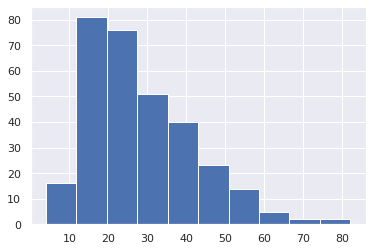

In [29]:
# возьмем натуральный логариф от длины и будем исопльзовать его в расчетах
len_of_commit_message = np.log(np.array(messages_len))

# распределение длины коммитов
pd.Series(np.array(messages_len)).hist()

Text(0.5, 1.0, 'График соотношения комитов и багов')

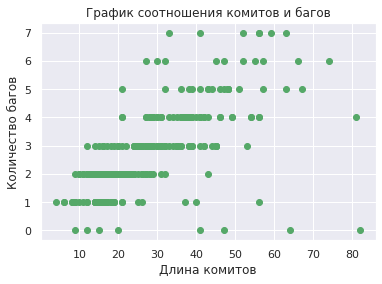

In [30]:
fig, ax = plt.subplots()
plt.plot(pd.Series(np.array(messages_len)), Y_train, 'o', color='g')
ax.set_xlabel('Длина комитов')
ax.set_ylabel('Количество багов')
ax.set_title('График соотношения комитов и багов')

In [31]:
# коэффициент корреляции пирсона для длины коммита и числа багов
pearsonr(np.array(messages_len), Y_train)

(0.6500791328205024, 1.2868944735760507e-38)

Коэффицент корреляции между длиной комитов и числом багов составляет 0,65.

In [32]:
X_train.commit_message = len_of_commit_message

In [33]:
X_train.head()

,commit_message,commit_author_Alice,commit_author_Bob,commit_author_Carol,commit_author_Dabe,commit_author_Eve,commit_author_Mallory,commit_author_Peggy,commit_author_Trudy,commit_author_Victor,...,repository_name_conductor,repository_name_dockers,repository_name_mlm,repository_name_sensor,repository_name_standard,year,month,day,hour,weekday
0,3.637586,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,2020,6,12,14.43,4
1,3.218876,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,2020,6,12,11.88,4
2,3.610918,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,2020,6,11,15.32,3
3,3.332205,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,2020,6,11,10.70,3
4,4.025352,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,2020,6,11,9.42,3


## Выбор модели

Для сравнения моделей будем использовать MSE и оценку эффективности моделей из библиотеки sklearn (.score)

### Стандартизируем данные и разделим на обучающую и тестовую выборки

In [34]:
from sklearn.preprocessing import StandardScaler

In [35]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [36]:
X_train_scaled = scaler.transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled,
                                      columns=X_train.columns)

In [37]:
# год один для всех наблюдений - удалим столбец
X_train_scaled = X_train_scaled.drop('year', axis=1)

In [38]:
X_train_scaled

,commit_message,commit_author_Alice,commit_author_Bob,commit_author_Carol,commit_author_Dabe,commit_author_Eve,commit_author_Mallory,commit_author_Peggy,commit_author_Trudy,commit_author_Victor,...,repository_name_agent,repository_name_conductor,repository_name_dockers,repository_name_mlm,repository_name_sensor,repository_name_standard,month,day,hour,weekday
0,0.841040,-0.080582,-0.080582,-0.114332,-0.395874,-0.172917,-0.520088,-0.080582,-0.172917,1.208436,...,-0.217479,-0.746853,-0.255523,2.803060,-0.700275,-0.321252,1.693227,-0.177321,0.180935,0.845578
1,0.002770,-0.080582,-0.080582,-0.114332,-0.395874,-0.172917,-0.520088,-0.080582,-0.172917,1.208436,...,-0.217479,-0.746853,-0.255523,2.803060,-0.700275,-0.321252,1.693227,-0.177321,-0.673941,0.845578
2,0.787649,-0.080582,-0.080582,-0.114332,-0.395874,-0.172917,-0.520088,-0.080582,-0.172917,1.208436,...,-0.217479,-0.746853,-0.255523,2.803060,-0.700275,-0.321252,1.693227,-0.290194,0.479304,0.203105
3,0.229657,-0.080582,-0.080582,-0.114332,-0.395874,-0.172917,-0.520088,-0.080582,-0.172917,1.208436,...,-0.217479,-0.746853,-0.255523,2.803060,-0.700275,-0.321252,1.693227,-0.290194,-1.069530,0.203105
4,1.617357,-0.080582,-0.080582,-0.114332,-0.395874,-0.172917,-0.520088,-0.080582,-0.172917,1.208436,...,-0.217479,-0.746853,-0.255523,2.803060,-0.700275,-0.321252,1.693227,-0.290194,-1.498645,0.203105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,-0.890710,-0.080582,-0.080582,-0.114332,2.526055,-0.172917,-0.520088,-0.080582,-0.172917,-0.827516,...,-0.217479,-0.746853,-0.255523,-0.356753,1.428011,-0.321252,-1.418830,1.064289,-0.331990,-1.724316
306,0.229657,-0.080582,-0.080582,-0.114332,2.526055,-0.172917,-0.520088,-0.080582,-0.172917,-0.827516,...,-0.217479,-0.746853,-0.255523,-0.356753,1.428011,-0.321252,-1.418830,1.064289,-0.466089,-1.724316
307,1.041409,-0.080582,-0.080582,-0.114332,2.526055,-0.172917,-0.520088,-0.080582,-0.172917,-0.827516,...,-0.217479,-0.746853,-0.255523,-0.356753,1.428011,-0.321252,-1.418830,1.064289,-0.818096,-1.724316
308,-0.546661,-0.080582,-0.080582,-0.114332,2.526055,-0.172917,-0.520088,-0.080582,-0.172917,-0.827516,...,-0.217479,-0.746853,-0.255523,-0.356753,1.428011,-0.321252,-1.418830,1.064289,-0.858326,-1.724316


In [39]:
from sklearn.model_selection import train_test_split

In [40]:
X_train_fin, X_val, y_train_fin, y_val = train_test_split(
    X_train_scaled, Y_train, test_size=0.3)

### LogisticRegression

In [41]:
from sklearn.linear_model import LogisticRegression

In [42]:
clf = LogisticRegression()

In [43]:
clf.fit(X_train_fin, y_train_fin)

LogisticRegression()

In [44]:
y_logist_pred = clf.predict(X_val)

##### MSE

In [45]:
mse_logistic = np.mean((y_val-y_logist_pred)**2)
print('mse', mse_logistic)
print('sqrt(mse)', mse_logistic**0.5)
print('avg_error', np.mean(abs(y_val-y_logist_pred)))

mse 1.4086021505376345
sqrt(mse) 1.1868454619442392
avg_error 0.7204301075268817


(array([ 3.,  0., 14.,  0., 42.,  0., 27.,  0.,  5.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-2.  , -1.55, -1.1 , -0.65, -0.2 ,  0.25,  0.7 ,  1.15,  1.6 ,
         2.05,  2.5 ,  2.95,  3.4 ,  3.85,  4.3 ,  4.75,  5.2 ,  5.65,
         6.1 ,  6.55,  7.  ]),
 <BarContainer object of 20 artists>)

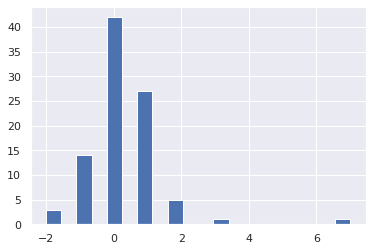

In [46]:
plt.hist(y_val-y_logist_pred, bins=20)

In [47]:
clf.score(X_val, y_val)

0.45161290322580644

### LinearRegression

In [48]:
from sklearn.linear_model import LinearRegression

In [49]:
regression = LinearRegression()

In [50]:
regression.fit(X_train_fin, y_train_fin)

LinearRegression()

In [51]:
y_linear_pred = regression.predict(X_val)

In [52]:
(y_val - y_linear_pred).describe()

count    93.000000
mean      0.174045
std       0.826397
min      -2.163923
25%      -0.390291
50%       0.115570
75%       0.704013
max       2.358641
Name: bugs, dtype: float64

(array([ 1.,  0.,  1.,  0.,  1.,  5.,  9.,  9.,  7., 11., 11., 11.,  7.,
         8.,  3.,  2.,  3.,  0.,  2.,  2.]),
 array([-2.16392332, -1.93779508, -1.71166684, -1.4855386 , -1.25941036,
        -1.03328212, -0.80715388, -0.58102564, -0.3548974 , -0.12876916,
         0.09735908,  0.32348732,  0.54961556,  0.7757438 ,  1.00187204,
         1.22800028,  1.45412852,  1.68025676,  1.906385  ,  2.13251324,
         2.35864148]),
 <BarContainer object of 20 artists>)

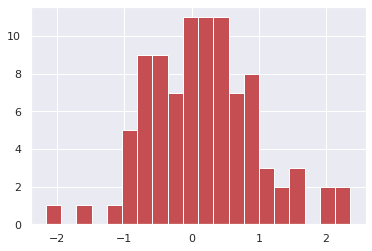

In [53]:
plt.hist(y_val-y_linear_pred, bins=20,color='r')

##### MSE

In [54]:
mse = np.mean((y_val-y_linear_pred)**2)
print('mse', mse)
print('sqrt(mse)', mse**0.5)
print('avg_error', np.mean(abs(y_val-y_linear_pred)))

mse 0.7058799089993211
sqrt(mse) 0.8401665959792266
avg_error 0.647953734673244


In [55]:
regression.score(X_val, y_val)

0.7010793511097176

### KNN

In [56]:
from sklearn.neighbors import KNeighborsRegressor

In [57]:
knn = KNeighborsRegressor(weights = 'distance')

In [58]:
knn.fit(X_train_fin, y_train_fin)

KNeighborsRegressor(weights='distance')

In [59]:
y_knn_pred = knn.predict(X_val)

##### MSE

In [60]:
mse_knn = np.mean((y_val-y_knn_pred)**2)
print('mse', mse_knn)
print('sqrt(mse)', mse_knn**0.5)
print('avg_error', np.mean(abs(y_val-y_knn_pred)))

mse 1.612350366854639
sqrt(mse) 1.2697835905596824
avg_error 0.9222828417618477


(array([ 1.,  2.,  0.,  5.,  6.,  7., 15., 13., 11.,  8.,  8.,  3.,  3.,
         1.,  2.,  2.,  3.,  0.,  1.,  2.]),
 array([-2.58453918, -2.25531222, -1.92608526, -1.5968583 , -1.26763134,
        -0.93840438, -0.60917742, -0.27995047,  0.04927649,  0.37850345,
         0.70773041,  1.03695737,  1.36618433,  1.69541129,  2.02463825,
         2.35386521,  2.68309216,  3.01231912,  3.34154608,  3.67077304,
         4.        ]),
 <BarContainer object of 20 artists>)

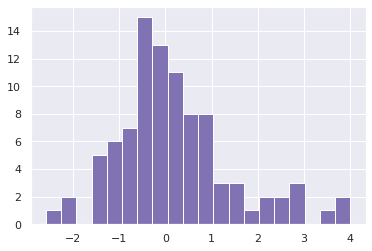

In [61]:
plt.hist(y_val-y_knn_pred, bins=20, color='m')

In [62]:
knn.score(X_val, y_val)

0.317214144000892

### Tree

In [63]:
from sklearn.tree import DecisionTreeClassifier

In [64]:
tree = DecisionTreeClassifier(max_depth=100)

In [65]:
tree.fit(X_train_fin, y_train_fin)

DecisionTreeClassifier(max_depth=100)

In [66]:
y_tree_pred = tree.predict(X_val)

##### MSE

In [67]:
mse_tree = np.mean((y_val-y_tree_pred)**2)
print('mse', mse_tree)
print('sqrt(mse)', mse_tree**0.5)
print('avg_error', np.mean(abs(y_val-y_tree_pred)))

mse 2.053763440860215
sqrt(mse) 1.4330957542537814
avg_error 0.8924731182795699


(array([ 4.,  0.,  0.,  0.,  0., 20.,  0., 40.,  0.,  0., 19.,  0.,  4.,
         0.,  0.,  2.,  0.,  2.,  0.,  2.]),
 array([-3. , -2.6, -2.2, -1.8, -1.4, -1. , -0.6, -0.2,  0.2,  0.6,  1. ,
         1.4,  1.8,  2.2,  2.6,  3. ,  3.4,  3.8,  4.2,  4.6,  5. ]),
 <BarContainer object of 20 artists>)

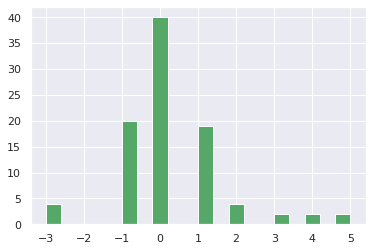

In [68]:
plt.hist(y_val-y_tree_pred, bins=20, color='g')

In [69]:
tree.score(X_val, y_val)

0.43010752688172044

### Сравним результаты расчетов по нескольким моделям

In [70]:
# расчет MSE
print('Mean Squared Error:\n\n\
logistic reg = %f\n\
linear reg = %f\n\
knn = %f\n\
tree = %f' %(
    mean_squared_error(y_val, y_logist_pred), 
    mean_squared_error(y_val, y_linear_pred), 
    mean_squared_error(y_val, y_knn_pred), 
    mean_squared_error(y_val, y_tree_pred)))

Mean Squared Error:

logistic reg = 1.408602
linear reg = 0.705880
knn = 1.612350
tree = 2.053763


По величине MSE наилучший результат показывает линейная регрессия

In [71]:
# расчет score
print('Models score :\n\n\
logistic reg = %f\n\
linear reg = %f\n\
knn = %f\n\
tree = %f' %(
    clf.score(X_val, y_val), 
    regression.score(X_val, y_val), 
    knn.score(X_val, y_val), 
    tree.score(X_val, y_val)))

Models score :

logistic reg = 0.451613
linear reg = 0.701079
knn = 0.317214
tree = 0.430108


Оценка эффективности модели также показывает преимущество линейной регрессии относительно других. Посмотрим на графиках:

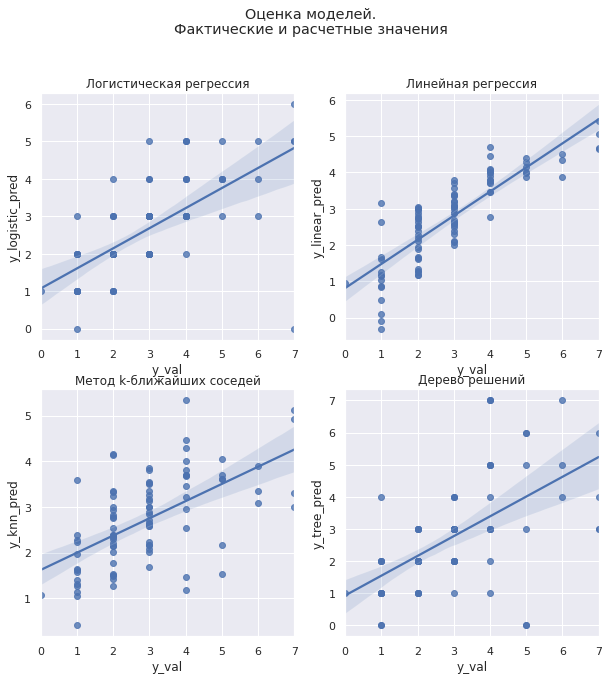

In [72]:
# визуализируем
list_of_y_all = [np.array(y_val),y_logist_pred, y_linear_pred, 
             y_knn_pred, y_tree_pred]

df00 = pd.DataFrame(list_of_y_all).transpose()
df00.columns=['y_val', 'y_logistic_pred', 'y_linear_pred', 
              'y_knn_pred', 'y_tree_pred']

fig, ax =plt.subplots(2,2)
sns.regplot( ax=ax[0,0], x='y_val', y='y_logistic_pred', data = df00)
sns.regplot(ax=ax[0,1], x='y_val', y='y_linear_pred', data = df00)
sns.regplot( ax=ax[1,0], x='y_val', y='y_knn_pred', data = df00)
sns.regplot(ax=ax[1,1], x='y_val', y='y_tree_pred', data = df00)

fig.suptitle('Оценка моделей.\nФактические и расчетные значения',
             y=1.0)

ax[0,0].set_title('Логистическая регрессия')
ax[0,1].set_title('Линейная регрессия')
ax[1,0].set_title('Метод k-ближайших соседей')
ax[1,1].set_title('Дерево решений')


fig.set_figheight(10)
fig.set_figwidth(10)

Выберем модель линейной регрессии для дальнейшей калибровки.

## Настроим гиперпараметры

In [73]:
model = LinearRegression()

In [74]:
# посмотрим параметры модели
model.get_params()

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}

In [75]:
# актуально настраивать n_jobs
n_jobs = range(1,15)

hyperparameter_grid = {'n_jobs': n_jobs}

from sklearn.model_selection import RandomizedSearchCV

random_cv = RandomizedSearchCV(estimator=model,
    param_distributions=hyperparameter_grid,
    n_iter=10, 
    scoring = 'neg_mean_absolute_error',
    n_jobs = -1, verbose = 1, 
    return_train_score = True)

In [76]:
random_cv.fit(X_train_fin, y_train_fin)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.4s finished


RandomizedSearchCV(estimator=LinearRegression(), n_jobs=-1,
                   param_distributions={'n_jobs': range(1, 15)},
                   return_train_score=True, scoring='neg_mean_absolute_error',
                   verbose=1)

In [77]:
random_cv.best_estimator_

LinearRegression(n_jobs=7)

## Построим итоговую модель

In [78]:
model_fin = random_cv.best_estimator_

In [79]:
model_fin.fit(X_train_fin, y_train_fin)

LinearRegression(n_jobs=7)

In [80]:
y_pred_fin = model_fin.predict(X_val)

In [81]:
mse_fin = np.mean((y_val-y_pred_fin)**2)
print('mse', mse_fin)
print('sqrt(mse)', mse_fin**0.5)
print('avg_error', np.mean(abs(y_val-y_pred_fin)))

mse 0.7058799089993211
sqrt(mse) 0.8401665959792266
avg_error 0.647953734673244


(array([ 1.,  0.,  1.,  0.,  1.,  5.,  9.,  9.,  7., 11., 11., 11.,  7.,
         8.,  3.,  2.,  3.,  0.,  2.,  2.]),
 array([-2.16392332, -1.93779508, -1.71166684, -1.4855386 , -1.25941036,
        -1.03328212, -0.80715388, -0.58102564, -0.3548974 , -0.12876916,
         0.09735908,  0.32348732,  0.54961556,  0.7757438 ,  1.00187204,
         1.22800028,  1.45412852,  1.68025676,  1.906385  ,  2.13251324,
         2.35864148]),
 <BarContainer object of 20 artists>)

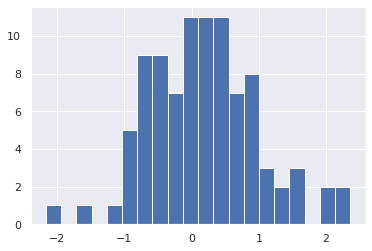

In [82]:
plt.hist(y_val-y_pred_fin, bins=20)

In [83]:
model_fin.score(X_val, y_val)

0.7010793511097176

Настройка параметров не принесла улучшения модели.

## Вывод

Получена модель на основе линейной регрессии, которая прогнозирует количество bugs. Коэффициент детерминации модели составляет 0,70. 

In [84]:
MAE_base = np.mean(abs(y_val-np.median(y_train_fin)))
MAE_model = np.mean(abs(y_val-y_pred_fin ))

In [85]:
print('Средння абсолютная ошибка:\n\
при прогнозе по медиане составляет %f\n\
при прогнозе по модели составляет %f' % (MAE_base, MAE_model))


Средння абсолютная ошибка:
при прогнозе по медиане составляет 1.161290
при прогнозе по модели составляет 0.647954


Средняя абсолютная ошибка прогноза по модели на 55% меньше, чем прогноз по медиане. Модель дает новую информацию в сравнении с прогнозом по медиане.

Возможные пути улучшения прогноза: более детально проработать текстовые данные коммитов, расширить перечень применяемых моделей, опробовать модели с более гибкой настройкой гиперпараметров. 